# Load packages

In [17]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad


In [18]:
import sys
print(sys.executable)


/home/maa81gb/anaconda3/envs/scFates_py3.11/bin/python


In [19]:
import sys
print("\n".join(sys.path))


/home/maa81gb/anaconda3/envs/scFates_py3.11/lib/python311.zip
/home/maa81gb/anaconda3/envs/scFates_py3.11/lib/python3.11
/home/maa81gb/anaconda3/envs/scFates_py3.11/lib/python3.11/lib-dynload

/home/maa81gb/anaconda3/envs/scFates_py3.11/lib/python3.11/site-packages


# Import data

In [45]:
#adata = ad.read_h5ad("/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_time_pub.h5ad")
#'/storage/users/data/PANC/MA_time_adata_10066.h5ad'
#adata = ad.read_h5ad("/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_time_pub.h5ad")
#adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_palantir.h5ad')
#adata = ad.read_h5ad("/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust_time_pub.h5ad")
#adata = ad.read_h5ad("/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust.h5ad")
adata = ad.read_h5ad("/storage/users/data/PANC/H5AD_file/adata_filtered_no2D_hvg_clust.h5ad")#last adta according to github

In [46]:
adata

AnnData object with n_obs × n_vars = 6281 × 1992
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

#  Count number of cells treated with GEM in the leiden clusters and report percentage of all cells within the cluster

In [58]:
import os

# Define your preferred default save directory
save_dir = "figures"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Change the working directory to the save directory
os.chdir(save_dir)


210
164
416
330


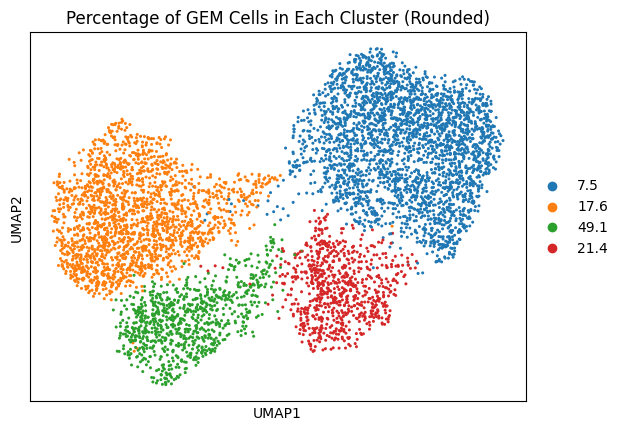

In [72]:
# Assuming 'adata' is your AnnData object
# Calculate the percentage of 'GEM_2' cells in each Leiden cluster
clusters = adata.obs['leiden'].unique()
percent_gem = {}

for cluster in clusters:
    cluster_cells = adata[adata.obs['leiden'] == cluster]
    num_cells_in_cluster = len(cluster_cells)
    #gem_cells_in_cluster = cluster_cells[cluster_cells.obs['condition'] == 'GEM_2']
    gem_cells_in_cluster = cluster_cells[cluster_cells.obs['condition'].str.contains('GEM', regex=True)]
    num_gem_cells_in_cluster = len(gem_cells_in_cluster)
    print(num_gem_cells_in_cluster)
    # Calculate and round the percentage to one decimal place
    percent_gem[cluster] = round(num_gem_cells_in_cluster / num_cells_in_cluster * 100, 1)

# Add the calculated percentages as a new column to the adata.obs
adata.obs['percent_gem'] = adata.obs['leiden'].map(percent_gem)


# Plotting the percentage on UMAP
sc.pl.umap(adata, color='percent_gem', title='Percentage of GEM Cells in Each Cluster (Rounded)',  save="_percent_gem.png")




In [59]:
import os
os.getcwd()


'/home/maa81gb/single-cell-beta/figures'

'percent_gem' is not numeric. Attempting to convert.


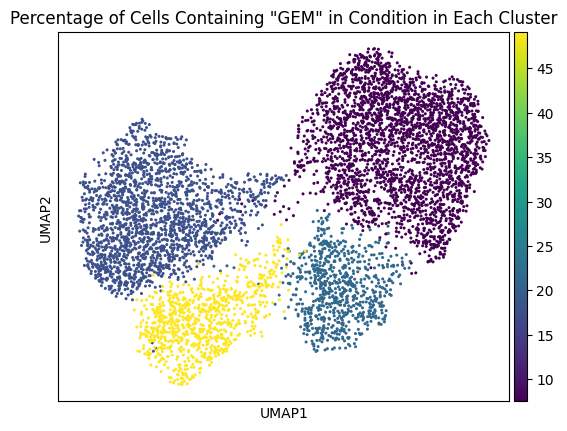

In [74]:
# Check if 'percent_gem' column exists
if 'percent_gem' not in adata.obs.columns:
    print("percent_gem column does not exist in adata.obs")
else:
    # Check for NaN values and replace them with a default value (e.g., 0)
    if adata.obs['percent_gem'].isna().any():
        print("NaN values found in 'percent_gem'. Replacing with 0.")
        adata.obs['percent_gem'].fillna(0, inplace=True)

    # Ensure that 'percent_gem' contains numeric data
    if not pd.api.types.is_numeric_dtype(adata.obs['percent_gem']):
        print("'percent_gem' is not numeric. Attempting to convert.")
        adata.obs['percent_gem'] = pd.to_numeric(adata.obs['percent_gem'], errors='coerce')

    # Plotting the percentage on UMAP
    sc.pl.umap(adata, color='percent_gem', title='Percentage of Cells Containing "GEM" in Condition in Each Cluster', save= "Percentage_og_GEM_condition.png")




In [75]:
import pandas as pd
import scipy.stats as stats

# Store results
fisher_results = []

clusters = adata.obs['leiden'].unique()

# Count total GEM and non-GEM cells in the dataset
total_gem_cells = (adata.obs['condition'].str.contains('GEM', regex=True)).sum()
total_non_gem_cells = len(adata) - total_gem_cells

for cluster in clusters:
    cluster_cells = adata.obs['leiden'] == cluster
    
    # Count GEM and non-GEM cells in the cluster
    num_gem_in_cluster = (adata.obs.loc[cluster_cells, 'condition'].str.contains('GEM', regex=True)).sum()
    num_non_gem_in_cluster = cluster_cells.sum() - num_gem_in_cluster

    # Count GEM and non-GEM cells outside the cluster
    num_gem_outside_cluster = total_gem_cells - num_gem_in_cluster
    num_non_gem_outside_cluster = total_non_gem_cells - num_non_gem_in_cluster

    # Construct the contingency table
    contingency_table = [[num_gem_in_cluster, num_non_gem_in_cluster],
                         [num_gem_outside_cluster, num_non_gem_outside_cluster]]
    
    # Perform Fisher’s exact test
    odds_ratio, p_value = stats.fisher_exact(contingency_table, alternative='greater')

    # Store results
    fisher_results.append([cluster, num_gem_in_cluster, num_non_gem_in_cluster, 
                           num_gem_outside_cluster, num_non_gem_outside_cluster, 
                           odds_ratio, p_value])

# Convert results to DataFrame
fisher_df = pd.DataFrame(fisher_results, 
                         columns=['Cluster', 'GEM in Cluster', 'Non-GEM in Cluster',
                                  'GEM outside Cluster', 'Non-GEM outside Cluster',
                                  'Odds Ratio', 'P-Value'])




In [76]:
print(fisher_df)

  Cluster  GEM in Cluster  Non-GEM in Cluster  GEM outside Cluster  \
0       0             210                2579                  910   
1       3             164                 601                  956   
2       2             416                 432                  704   
3       1             330                1549                  790   

   Non-GEM outside Cluster  Odds Ratio        P-Value  
0                     2582    0.231038   1.000000e+00  
1                     4560    1.301596   3.655049e-03  
2                     4729    6.468540  5.330383e-116  
3                     3612    0.974054   6.544179e-01  


## Bar plot

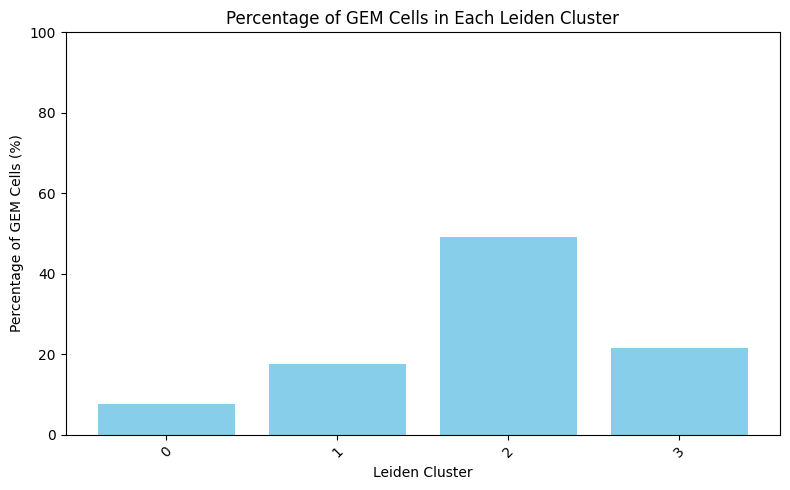

In [79]:
import matplotlib.pyplot as plt

# Create bar plot
plt.figure(figsize=(8, 5))
clusters_sorted = sorted(percent_gem.keys(), key=lambda x: int(x))  # sort clusters numerically if possible

# Plot the bars
plt.bar(clusters_sorted, [percent_gem[c] for c in clusters_sorted], color='skyblue')

# Add labels and title
plt.xlabel('Leiden Cluster')
plt.ylabel('Percentage of GEM Cells (%)')
plt.title('Percentage of GEM Cells in Each Leiden Cluster')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # optional: fix y-axis to percentage scale

# Show the plot
plt.tight_layout()

plt.savefig("bar plot Containing GEM in Condition in Each Cluster.png", dpi=300)
plt.show()

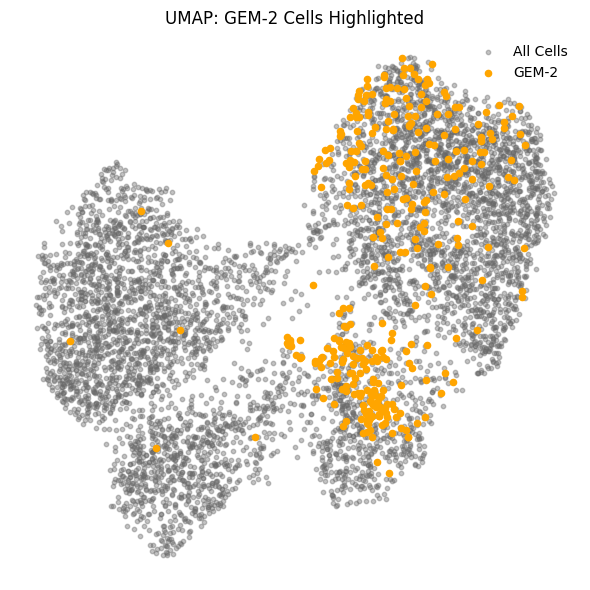

In [80]:
import matplotlib.pyplot as plt

# Get UMAP coordinates
umap = adata.obsm['X_umap']
is_gem2 = adata.obs['condition'] == 'GEM_2'

# Create the plot
plt.figure(figsize=(6, 6))

# 1. Plot all cells in dark gray
plt.scatter(
    umap[:, 0],
    umap[:, 1],
    color='dimgray',
    alpha=0.4,
    s=10,
    label='All Cells'
)

# 2. Overlay GEM-2 cells in strong orange
plt.scatter(
    umap[is_gem2, 0],
    umap[is_gem2, 1],
    color='orange',
    alpha=1.0,
    s=20,
    label='GEM-2'
)

# Aesthetics
plt.title('UMAP: GEM-2 Cells Highlighted')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(frameon=False)
plt.axis('off')  # Optional: clean look
plt.tight_layout()
plt.savefig("only GEM_2 cells Highlighted.png", dpi=300)
plt.show()


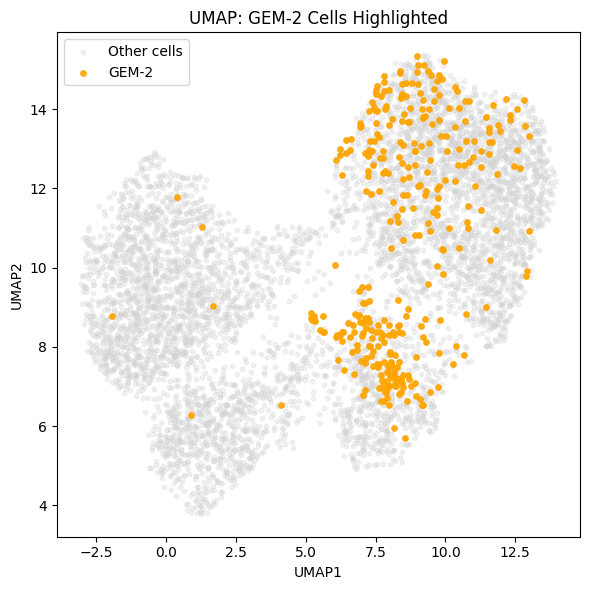

In [81]:
# Get UMAP coordinates
umap = adata.obsm['X_umap']
is_gem2 = adata.obs['condition'] == "GEM_2"

# Plot manually with matplotlib
plt.figure(figsize=(6, 6))

# Plot all cells in gray
plt.scatter(umap[:, 0], umap[:, 1], color='lightgray', alpha=0.3, s=10, label='Other cells')

# Plot GEM-2 cells in orange
plt.scatter(umap[is_gem2, 0], umap[is_gem2, 1], color='orange', alpha=0.9, s=15, label='GEM-2')

# Labeling
plt.title('UMAP: GEM-2 Cells Highlighted')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.tight_layout()
plt.savefig("only GEM_2 cells Highlighted.png", dpi=300)
plt.show()




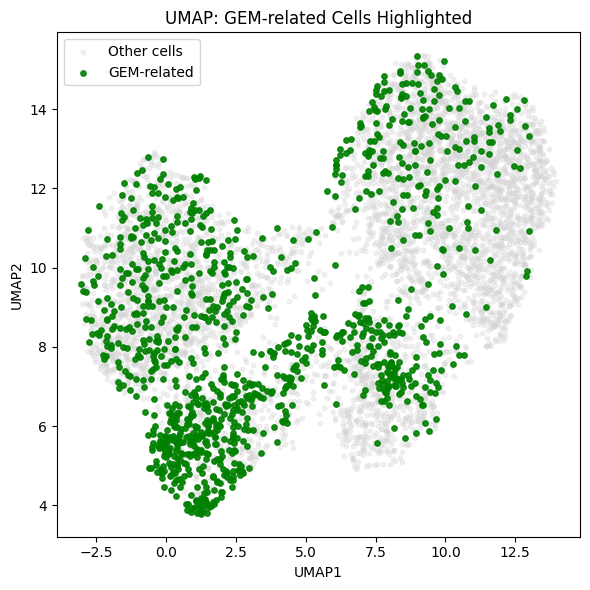

In [82]:
import matplotlib.pyplot as plt

# Get UMAP coordinates
umap = adata.obsm['X_umap']

# Create a boolean mask for GEM-related conditions
gem_conditions = ["GEM_2", "TGFb1_GEM_1", "TGFb1_GEM_2"]
is_gem2 = adata.obs['condition'].isin(gem_conditions)

# Plot manually with matplotlib
plt.figure(figsize=(6, 6))

# Plot all cells in gray
plt.scatter(umap[:, 0], umap[:, 1], color='lightgray', alpha=0.3, s=10, label='Other cells')

# Plot GEM-related cells in orange
plt.scatter(umap[is_gem2, 0], umap[is_gem2, 1], color='green', alpha=0.9, s=15, label='GEM-related')

# Labeling
plt.title('UMAP: GEM-related Cells Highlighted')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.tight_layout()
plt.savefig("GEM-related Cells Highlighted.png", dpi=300)
plt.show()


In [69]:
# Crosstab of cluster vs condition
condition_distribution = pd.crosstab(adata.obs['leiden'], adata.obs['condition'])
print(condition_distribution)


condition  CTRL_1  CTRL_2  GEM_2  TGFb1_1  TGFb1_2  TGFb1_GEM_1  TGFb1_GEM_2
leiden                                                                      
0            2207     316    189       52        4            9           12
1              10       1      4     1286      252          149          177
2               2       0     15      379       51          178          223
3             471      75    136       46        9           15           13


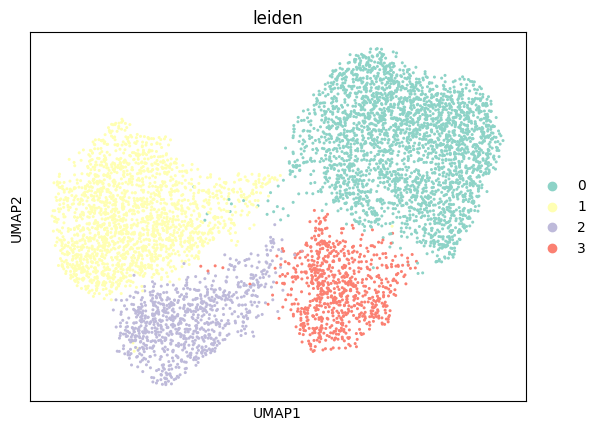

In [70]:
sc.pl.umap(adata, color='leiden', save='_leiden_clusters.png')
